In [1]:
import re
import pandas as pd

In [2]:
dfFull = pd.read_excel('akhvakhDBv4.xlsx')[[
    'word_id', 'borrowing', 'lemma_source', 'lemma_ipa', 'definition'
]]


In [3]:
dfFull.head(15)

,word_id,borrowing,lemma_source,lemma_ipa,definition
0,1,NaN,аба'далIи,a-b-a'-d-a-t͡ɬː-i,вечный; нескончаемый; *абадалIи чIили* загроб...
1,2,NaN,а/б/а'жве,a-b-a'-ʒʷ-e,общительность; *абажве голъIа аᴴде* необщитель...
2,3,NaN,а/б/ажу'рулъIа,a-b-a-ʒ-u'-r-u-t͡ɬ-a,1) общаться; поддерживать отношения; *чес̄уга-...
3,4,NaN,аба'хе,a-b-a'-χ-e,"отек, вздутие; _ратл._ *абахери*, _тлян._ *ахер*"
4,5,NaN,а/б/ахо̄'/рулъIа,a-b-a-χ-oː'-r-u-t͡ɬ-a,_понуд. от_ *абаху'рулъIа*; _ратл._ *абахейтIу...
5,6,NaN,а/б/аху'/рулъIа,a-b-a-χ-u'-r-u-t͡ɬ-a,"пухнуть, отекать; *рекьIа абахари* рука опухла..."
6,7,NaN,аба'шве,a-b-a'-ʃʷ-e,"встряска; _ратл._ *абашвери*, _тлян._ *гьабашер*"
7,8,NaN,а/б/ашу'рулъIа,a-b-a-ʃ-u'-r-u-t͡ɬ-a,"трусить, вытряхивать; выбивать (_пыль_); *къIе..."
8,9,NaN,а'ва,a'-w-a,"1) дом, здание; *ава гурулъIа* строить дом 2) ..."
9,10,NaN,ава'да/б/е,a-w-a'-d-a-b-e,"1) веселый, жизнерадостный; *авадабе ракIвалI..."


In [4]:
# фильтрация по (обнаруженным) заимствованиям
dfTarget = dfFull[pd.isna(dfFull['borrowing'])]

In [5]:
from collections import Counter

In [6]:
vowels = ['aː','a','ãː','ã',
          'iː','i','ĩ','ĩː',
          'eː','e','ẽː','ẽ',
          'uː','u','ũː','ũ',
          'oː','o','õː','õ']

vowels_stress = [v + "'" for v in vowels]

# список всех вариаций МФА-записей гласных
vowels_all = list()
for i in range(len(vowels)):
    vowels_all.append(vowels[i])
    vowels_all.append(vowels_stress[i])

In [7]:
# импорт таблицы соответствия букв и фонем
with open('ipaChart.txt', 'r', encoding='utf-8') as ipaF:
    rawTable = re.sub('\r', '', ipaF.read())
    ipaTable = [x.split(';') for x in rawTable.split('\n') if len(x.split(';')) == 2]
    # сортировка по длине записи фонемы в МФА
    ipaTable = sorted(ipaTable, key=lambda x: len(x[0]), reverse=True)

In [8]:
# еще раз функция перевода из кириллицы в МФА
def phonetizerPlus(word, ipaTable=ipaTable, removeSlash=True):
    
    # очистка от небуквенных символов и случайно попавших чанков
    word = re.sub('- ?', '', word.strip())
    word = re.sub('\([^\)][\)$]', '', word)
    
    phonWord = word
    
    # посимвольная транскрипция
    for pair in ipaTable:
        cyr = pair[0]
        repl = '-' + pair[1] + '-'
        phonWord = re.sub(cyr, repl, phonWord)
    
    # очистка получившейся записи
    phonWord = re.sub('--+', '-', phonWord)
    phonWord = re.sub("-'-", "'-", phonWord)
    phonWord = re.sub("- ", ' ', phonWord)
    phonWord = re.sub(" -", ' ', phonWord)
    if removeSlash:
        phonWord = re.sub("-/-", '-', phonWord)
        phonWord = re.sub("-'/", "'-", phonWord)
    phonWord = re.sub('--+', '-', phonWord).strip('-')
    if phonWord.endswith("-'"):
        phonWord = re.sub("-'", "'", phonWord)
    return (re.sub('i', 'I', word.lower()),
            phonWord)

In [9]:
def phonListMaker(ipa):
    return ipa.split('-')

### Частота сегментов

Для анализа частоты сегментов было решено удалить классные показатели и маркеры инфинитива.
В словаре такие показатели отделяются символом "/"; так как позиция показателей может быть любой, и показателей в слове может быть несколько, был реализован следующий алгоритм: 
- кириллическая запись делилась на сегменты по разделителю "/", эти сегменты проверялись на предмет соответствия самым частым формам: 

_"б", "м"_ и _"*улъIа"_. 

- Если то или иное соответствие было установлено, то найденный сегмент, а так же **все сегменты через один от него** удалялись из кириллической записи, и "очищенная" запись заново транскрибировалась. 
- Если же таких сегментов найдено не было, то сравнивалась длина каждого сегмента, и самый длинный сегмент (а так же все сегменты с той же четностью порядкового индекса) объявлялся целевым, а остальные удалялись

In [10]:
phonCounter = Counter()

for index, row in dfTarget.iterrows():
    # деление на сегменты
    spans = row['lemma_source'].split('/')
    # проверка наличия необходимых к очистке элементов
    if len(spans) > 1:
        parity = 2
        for i, x in enumerate(spans):
            if parity == 2:
                if x.endswith("улъIа") or x == "м" or x == "б":
                    parity = i % 2
        
        # если маркеры отличаются от заданных как условия поиска:
        if parity == 2:
            ipaLists = {i: len(phonListMaker(phonetizerPlus(x.upper())[1])) 
                        for i, x in enumerate(spans)}
            preParity = 0
            lastMax = 0
            
            # сравнение длины
            for k in ipaLists:
                n = ipaLists[k]
                if n > lastMax:
                    lastMax = n
                    preParity = k
            
            parity = (preParity + 1) % 2
            
            
            
        clearLemma = ''.join([x for i, x in enumerate(spans) if i % 2 != parity])
        _, clearIPA = phonetizerPlus(clearLemma.upper())
    
    # если слэшей в записи леммы не было, то мы считаем, что слово не содержит ненужнных для анализа показателй
    else:
        clearIPA = row['lemma_ipa']
    for phoneme in phonListMaker(re.sub("'", "", clearIPA)):
        phonCounter[phoneme] += 1

In [11]:
# общее количество участвующих в анализе фонем
total = sum(phonCounter.values())

In [12]:
phonFreqDF = pd.DataFrame(data={
    'phoneme': list(phonCounter.keys()),
    'count': list(phonCounter.values())
}, index=list(phonCounter.keys()))

phonFreqDF['total'] = total
phonFreqDF['percentage'] = phonFreqDF['count'] / phonFreqDF['total']

In [13]:
# проверка ошибок перевода в IPA
phonFreqDF[phonFreqDF['count'] < 25]

,phoneme,count,total,percentage
ʒʷ,ʒʷ,9,47698,0.000189
dʷ,dʷ,24,47698,0.000503
lː,lː,12,47698,0.000252
ћʷ,ћʷ,15,47698,0.000314
ãː,ãː,19,47698,0.000398
ĩː,ĩː,6,47698,0.000126
q͡χʷ,q͡χʷ,5,47698,0.000105
t’ʷ,t’ʷ,14,47698,0.000294
t͡sʷː,t͡sʷː,3,47698,0.000063
sʷː,sʷː,10,47698,0.000210


In [14]:
phonFreqDF['is_vowel'] = 0
for v in vowels:
    phonFreqDF.loc[v, 'is_vowel'] = 1

In [15]:
phonFreqDF['total_vowels'] = phonFreqDF['count'].where(phonFreqDF['is_vowel'] == 1).sum()
phonFreqDF['total_cons'] = phonFreqDF['count'].where(phonFreqDF['is_vowel'] == 0).sum()
phonFreqDF['group_percentage'] = phonFreqDF['count'] / abs(phonFreqDF['total'] * phonFreqDF['is_vowel'] - phonFreqDF['total_cons'])

In [16]:
phonFreqDF = phonFreqDF.sort_values(by=['count'], ascending=False)

In [17]:
for _, row in phonFreqDF.iterrows():
    print('\t'.join([
        row['phoneme'],
        str(round(row['percentage'] * 100, 3)) + "%",
        str(round(row['group_percentage'] * 100, 3)) + "%"
    ]))

a	17.359%	33.581%
e	10.235%	19.8%
i	9.317%	18.023%
u	6.007%	11.619%
r	4.025%	8.333%
l	3.266%	6.762%
d	3.254%	6.736%
o	3.166%	6.124%
b	1.992%	4.123%
oː	1.912%	3.699%
m	1.799%	3.724%
j	1.715%	3.55%
ɬ	1.577%	3.264%
h	1.495%	3.094%
n	1.468%	3.038%
q͡χ’ː	1.461%	3.025%
t’	1.258%	2.604%
t	1.237%	2.561%
q͡χː	1.222%	2.53%
t͡ʃ’	1.21%	2.504%
g	1.157%	2.396%
k’	1.08%	2.235%
sː	1.061%	2.196%
t͡ʃ	1.04%	2.153%
t͡ɬ	0.987%	2.044%
ʃ	0.975%	2.018%
k	0.969%	2.005%
χː	0.918%	1.901%
ћ	0.912%	1.888%
t͡ɬː	0.889%	1.84%
t͡ɬʼː	0.881%	1.823%
ã	0.866%	1.675%
aː	0.788%	1.525%
ʕ	0.748%	1.549%
eː	0.715%	1.383%
ʁ	0.694%	1.437%
t͡s’ː	0.583%	1.207%
ĩ	0.583%	1.127%
ʒ	0.581%	1.202%
χ	0.547%	1.133%
z	0.516%	1.068%
t͡ɬʼ	0.501%	1.037%
q͡χ’	0.465%	0.963%
s	0.449%	0.929%
ʃː	0.438%	0.907%
xː	0.386%	0.799%
ɬː	0.314%	0.651%
ũ	0.308%	0.596%
k’ʷ	0.256%	0.529%
w	0.241%	0.499%
p	0.241%	0.499%
kʼː	0.233%	0.482%
q͡χ	0.229%	0.473%
q͡χ’ʷː	0.222%	0.46%
ẽ	0.216%	0.418%
t͡sː	0.199%	0.412%
kʷ	0.189%	0.391%
hʷ	0.17%	0.352%
ʔ	0.166%	0.343%

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
for symbols in ipaTable:
    p = symbols[1]
    if p not in phonFreqDF.index:
        print(p, dfFull['lemma_ipa'].str.count(p).sum())

d͡ʒʷ 0
kʷː 0
t͡ɬʷː 0
mː 1


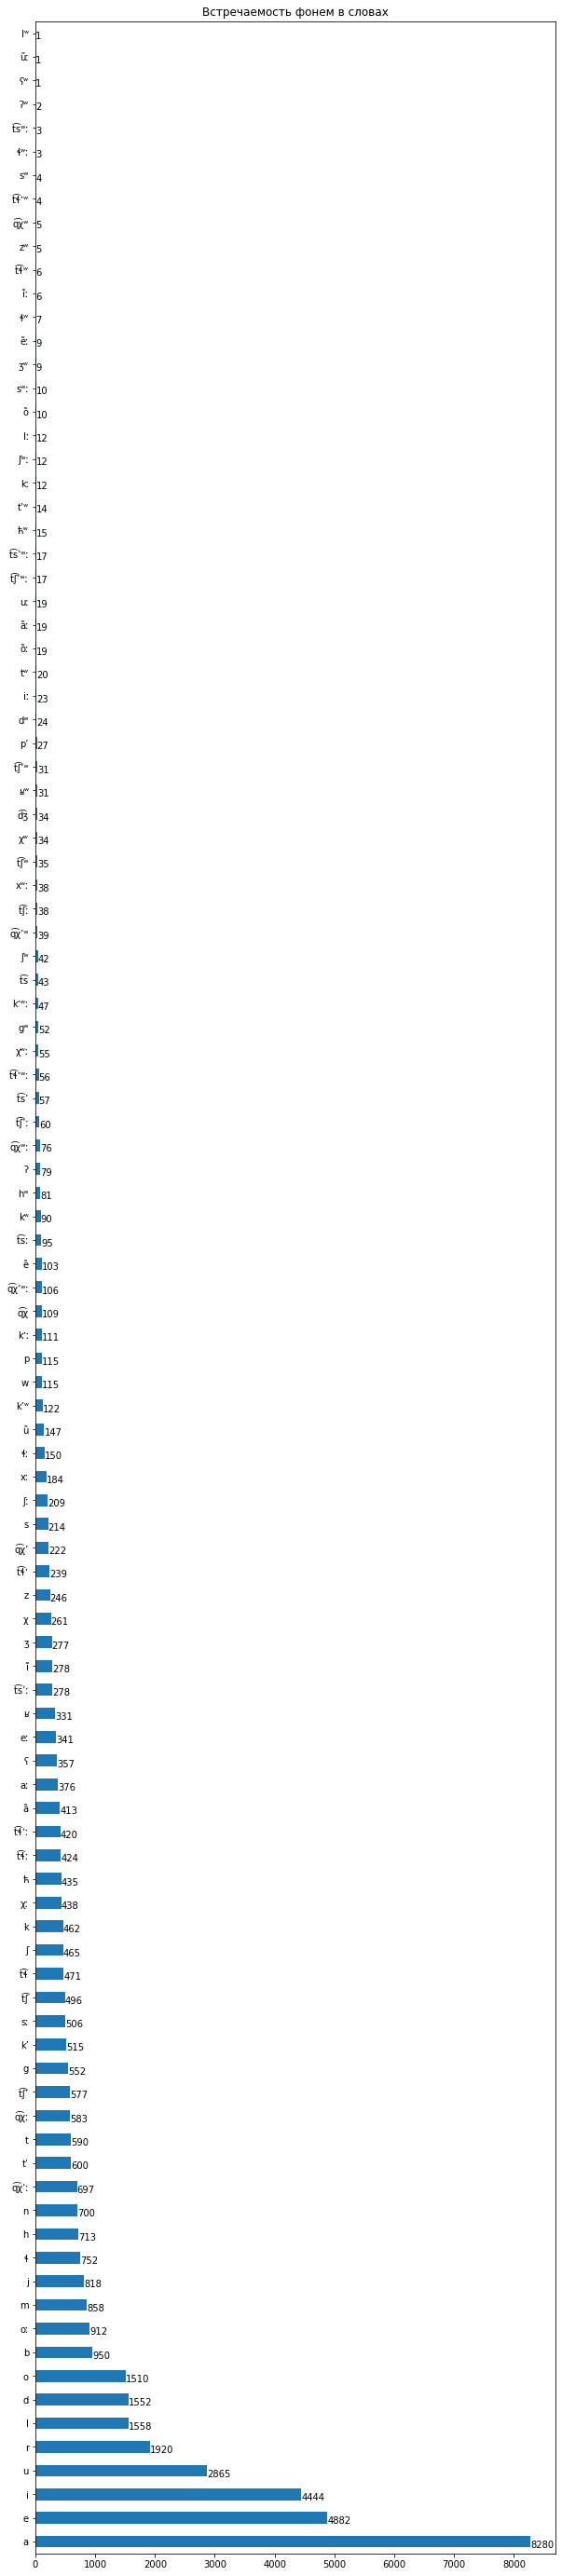

In [20]:
plt.figure(figsize=(10, 50))
ax = phonFreqDF['count'].plot.barh()
plt.title('Встречаемость фонем в словах')

for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()))

is_vowel
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

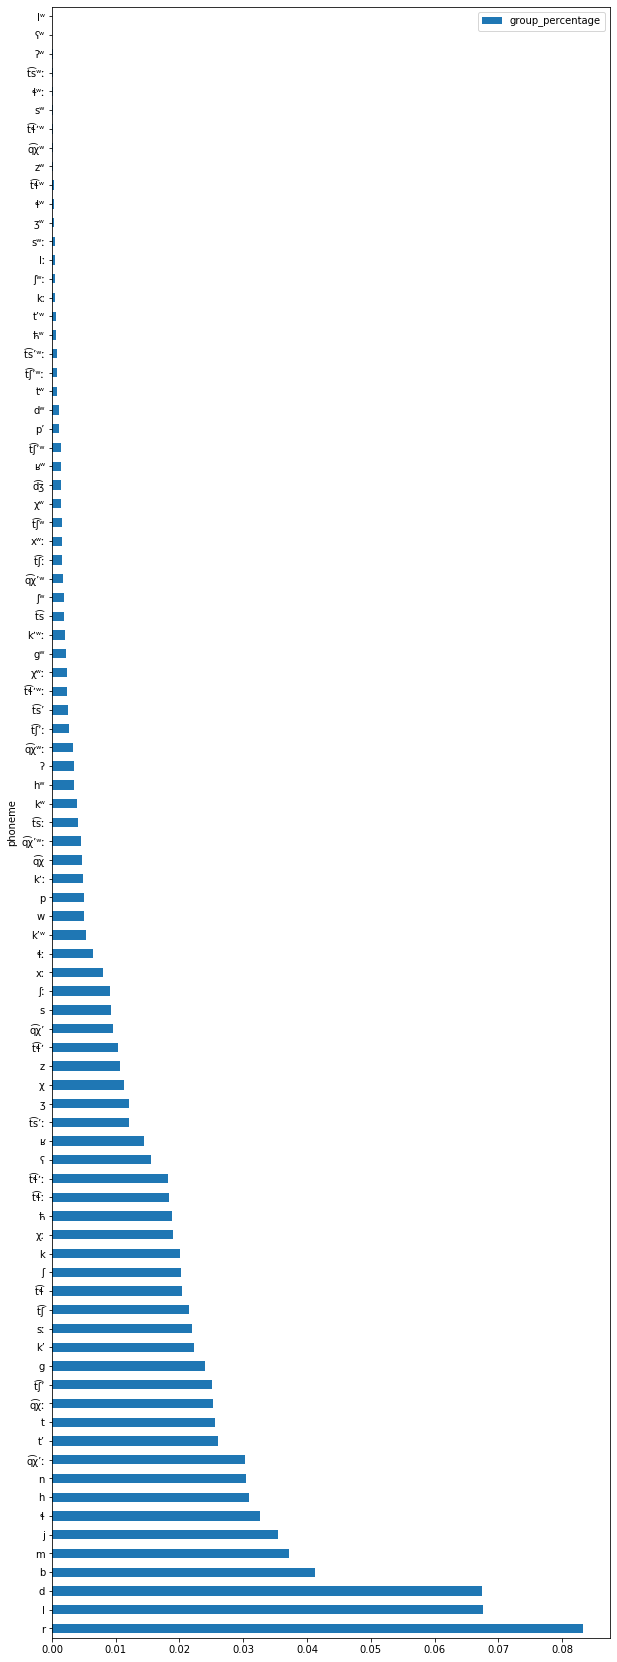

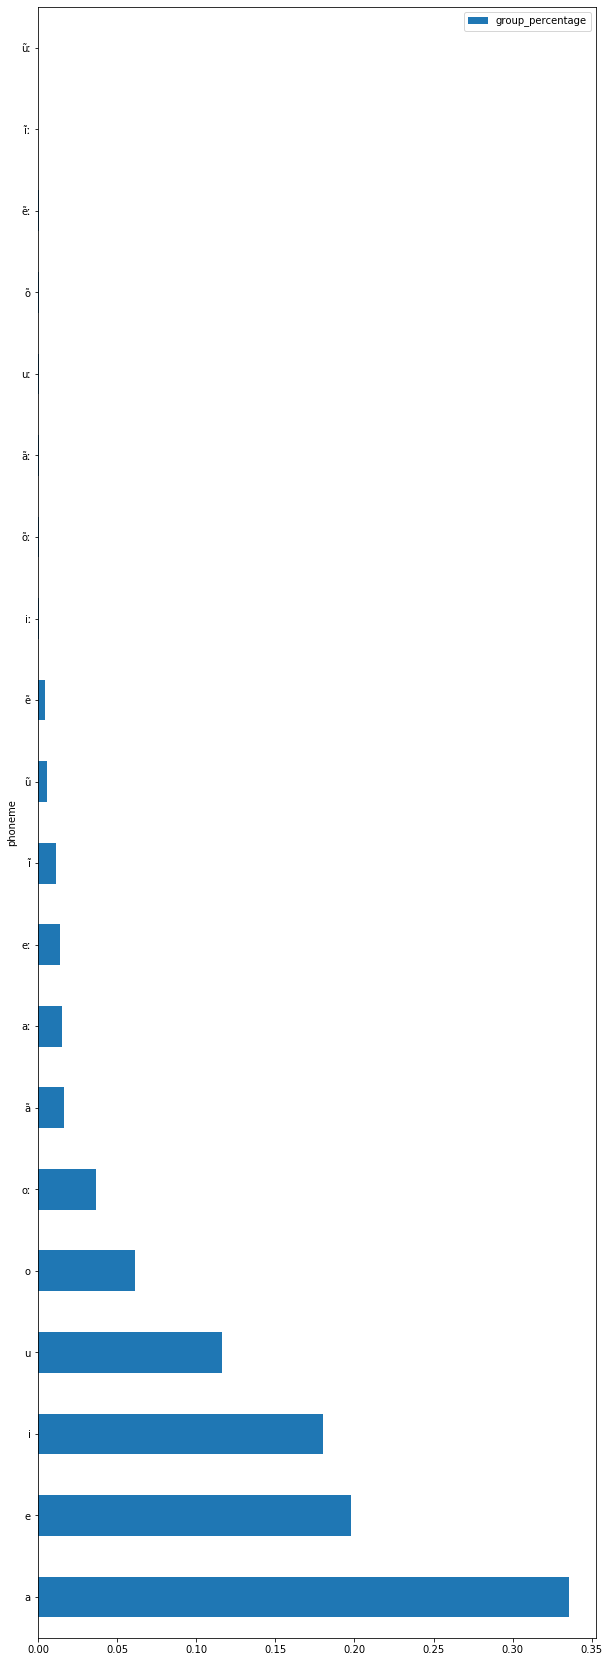

In [21]:
phonFreqDF.groupby('is_vowel').plot(y='group_percentage',x='phoneme', kind='barh', figsize=(10, 30))

### Анализ слоговой структуры

Для анализа слоговой структуры было решено удалить окончания инфинитивов.

In [22]:
vowelRegex = re.compile("[aeoiu]̃?ː?'?")

In [23]:
init_intro = []
init_intro_len = []
final_coda = []
final_coda_len = []
intervocal = []

stressed_vowels = []
stress_index = []

for index, row in dfTarget.iterrows():
    rInit = []
    rFinl = []
    rIntervocals = []
    
    ipaRaw = row['lemma_ipa']
    if ipaRaw.endswith('-u-t͡ɬ-a'):
        ipaSyl = phonListMaker(ipaRaw)[:-4]
        #ipaRaw = '-'.join(ipaSyl)
    else:
        ipaSyl = phonListMaker(ipaRaw)
        
    
    isVowelBool = "".join(['1' if vowelRegex.match(p) else '0' for p in ipaSyl])
    intervocalsLen = [len(x) for x in isVowelBool.split('1')]
    for iX, X in enumerate(intervocalsLen):
        if X == 0:
            rIntervocals.append('#')
        else:
            iStart = iX + sum(intervocalsLen[:iX])
            rIntervocals.append('-'.join(ipaSyl[iStart:iStart+X]))
    
    intInitLen = intervocalsLen[0]
    intFinalLen = intervocalsLen[-1]
    
    init_intro.append(rIntervocals[0])
    final_coda.append(rIntervocals[-1])
    init_intro_len.append(intInitLen)
    final_coda_len.append(intFinalLen)
    intervocal.append(rIntervocals[1:-1])
    
    sIndex = 0
    sVowel = "#"
    
    if "'" in ipaRaw:
        #print(ipaSyl)
        ipaOnlyVowels = [v for v in ipaSyl if v in vowels_all]
        #print(ipaOnlyVowels)
    
        for iV, v in enumerate(ipaOnlyVowels):
            if v in vowels_stress:
                sIndex = iV + 1
                sVowel = v
    
    stressed_vowels.append(sVowel)
    stress_index.append(sIndex)

In [24]:
dfTarget['first_init'] = init_intro
dfTarget['first_init_len'] = init_intro_len
dfTarget['last_finale'] = final_coda
dfTarget['last_finale_len'] = final_coda_len
dfTarget['intervocals'] = intervocal

C:\users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [25]:
dfTarget['stressed_vowels'] = stressed_vowels
dfTarget['stress_index'] = stress_index

C:\users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:

intervocal_len = []
for word in intervocal:
    
    ivWL = []
    for cluster in word:
        ivWL.append(len(cluster.split('-')))
    intervocal_len.append(ivWL)
        
dfTarget['intervocals_len'] = intervocal_len
dfTarget['n_syllables'] = [len(x)+1 for x in intervocal_len]

C:\users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [27]:
dfTarget

,word_id,borrowing,lemma_source,lemma_ipa,definition,first_init,first_init_len,last_finale,last_finale_len,intervocals,stressed_vowels,stress_index,intervocals_len,n_syllables
0,1,NaN,аба'далIи,a-b-a'-d-a-t͡ɬː-i,вечный; нескончаемый; *абадалIи чIили* загроб...,#,0,#,0,"[b, d, t͡ɬː]",a',2,"[1, 1, 1]",4
1,2,NaN,а/б/а'жве,a-b-a'-ʒʷ-e,общительность; *абажве голъIа аᴴде* необщитель...,#,0,#,0,"[b, ʒʷ]",a',2,"[1, 1]",3
2,3,NaN,а/б/ажу'рулъIа,a-b-a-ʒ-u'-r-u-t͡ɬ-a,1) общаться; поддерживать отношения; *чес̄уга-...,#,0,#,0,"[b, ʒ]",u',3,"[1, 1]",3
3,4,NaN,аба'хе,a-b-a'-χ-e,"отек, вздутие; _ратл._ *абахери*, _тлян._ *ахер*",#,0,#,0,"[b, χ]",a',2,"[1, 1]",3
4,5,NaN,а/б/ахо̄'/рулъIа,a-b-a-χ-oː'-r-u-t͡ɬ-a,_понуд. от_ *абаху'рулъIа*; _ратл._ *абахейтIу...,#,0,#,0,"[b, χ]",oː',3,"[1, 1]",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8000,8001,NaN,эᴴ'лъ̄ех̄у/нулъIа,ẽ'-ɬː-e-χː-u-n-u-t͡ɬ-a,уподобляться _кому-чему-л._; походить на _кого...,#,0,#,0,"[ɬː, χː]",ẽ',1,"[1, 1]",3
8001,8002,NaN,эᴴ'лъ̄о̄/нулъIа,ẽ'-ɬː-oː-n-u-t͡ɬ-a,"уподоблять _кому-чему-л._, делать _что-л._ пох...",#,0,#,0,[ɬː],ẽ',1,[1],2
8002,8003,NaN,э'лъ̄о̄/нулъIа,e'-ɬː-oː-n-u-t͡ɬ-a,"уподоблять _кому-чему-л._, делать _что-л._ пох...",#,0,#,0,[ɬː],e',1,[1],2
8003,8004,NaN,эᴴ'лъ̄у/нулъIа,ẽ'-ɬː-u-n-u-t͡ɬ-a,походить на кого-л.; уподобляться _кому-чему-л...,#,0,#,0,[ɬː],ẽ',1,[1],2


In [28]:
sonorList = [
    'l', 'lː', 'lʷ', 'm', 'mː', 'n', 'r'
]

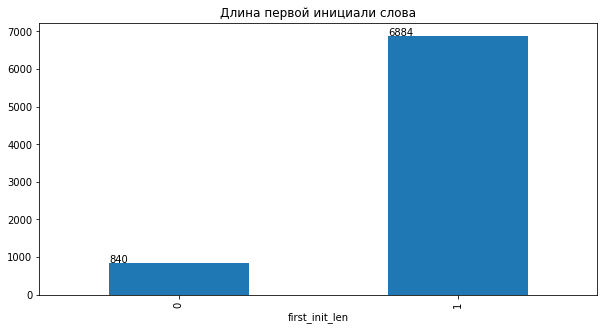

In [29]:
plt.figure(figsize=(10,5))
plt.title('Длина первой инициали слова')

ax = dfTarget.groupby('first_init_len')['word_id'].nunique().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()))

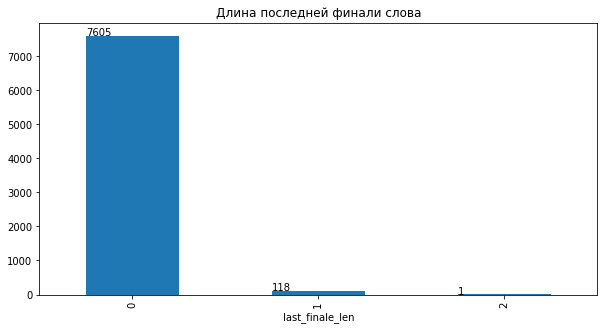

In [30]:
plt.figure(figsize=(10,5))
plt.title('Длина последней финали слова')
lf_count = dfTarget.groupby('last_finale_len')['word_id'].nunique()
ax = lf_count.plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()))

In [31]:
import seaborn as sbn


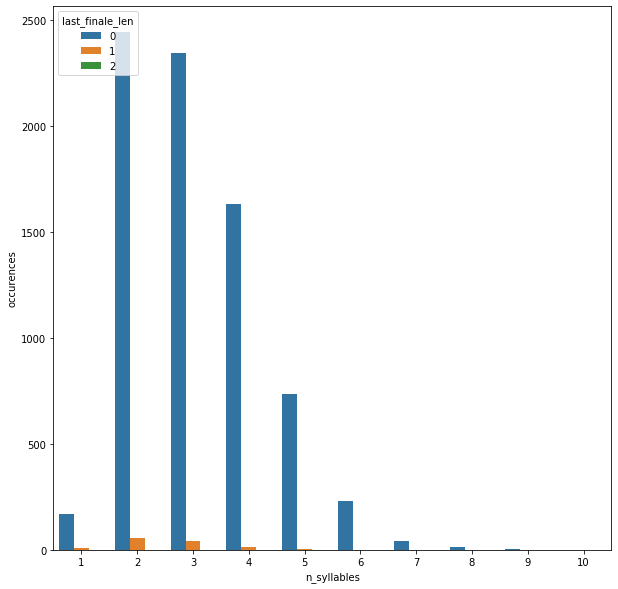

In [32]:
plt.figure(figsize=(10,10))
lfGB = dfTarget.groupby(['last_finale_len', 'n_syllables']).size().to_frame('occurences').reset_index()
sbn.barplot(x='n_syllables', y='occurences', hue='last_finale_len', data=lfGB)

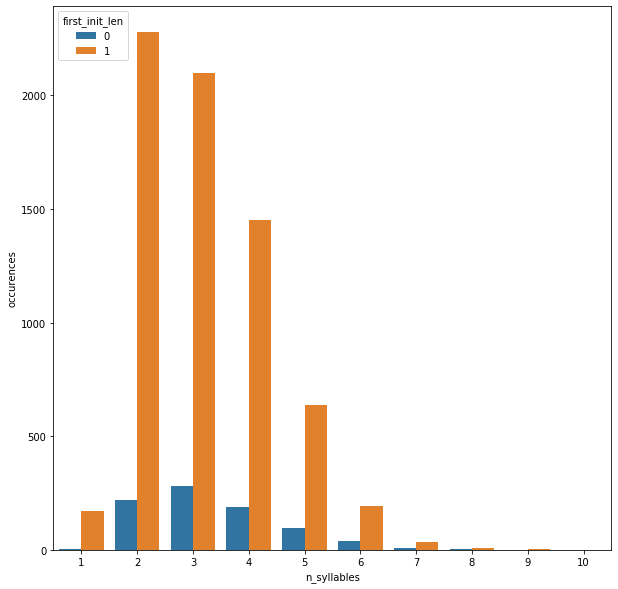

In [33]:
plt.figure(figsize=(10,10))
lfGB2 = dfTarget.groupby(['first_init_len', 'n_syllables']).size().to_frame('occurences').reset_index()
sbn.barplot(x='n_syllables', y='occurences', hue='first_init_len', data=lfGB2)

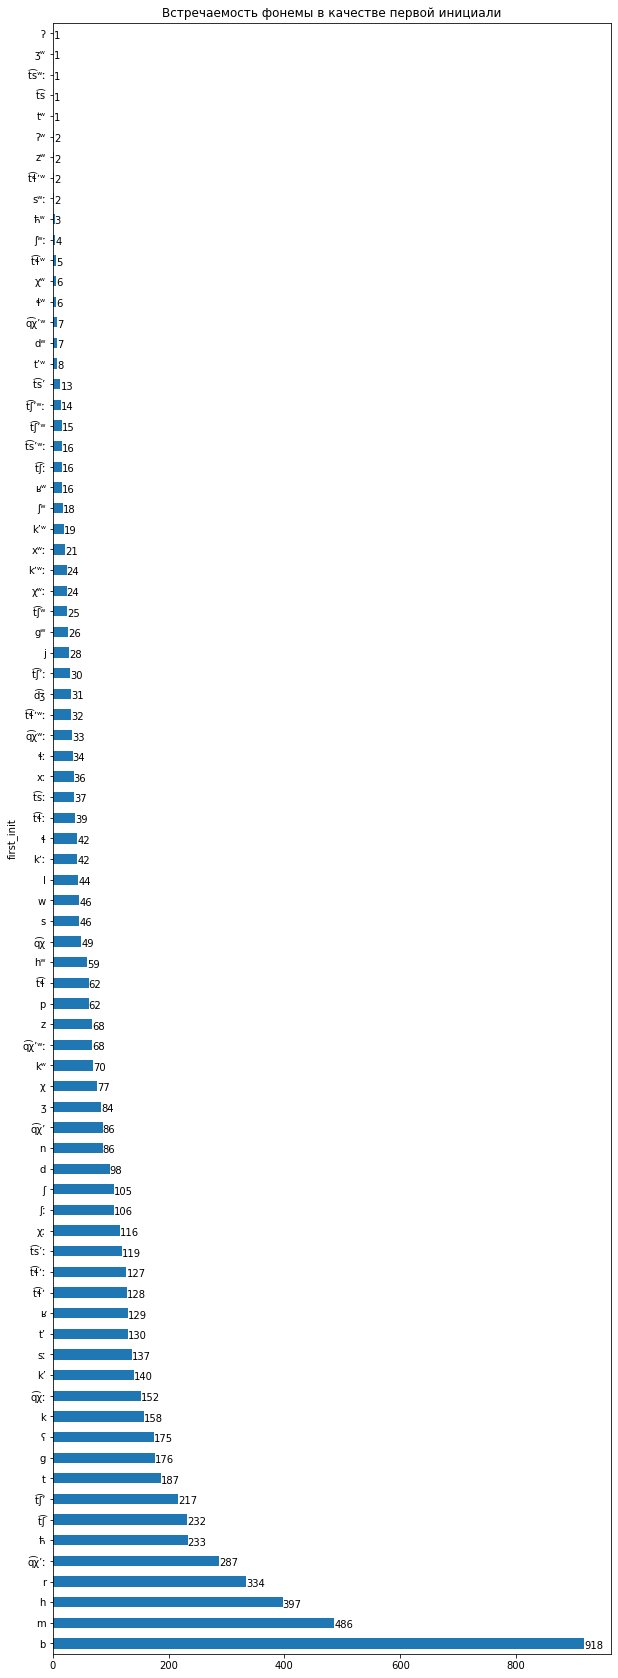

In [34]:
plt.figure(figsize=(10,30))
initConsCount = dfTarget.where(dfTarget.first_init_len > 0).groupby('first_init')['word_id'].nunique().sort_values(ascending=False)
plt.title('Встречаемость фонемы в качестве первой инициали')
plt.ylabel('Инициаль')
ax = initConsCount.plot(kind='barh', stacked=False)
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()))

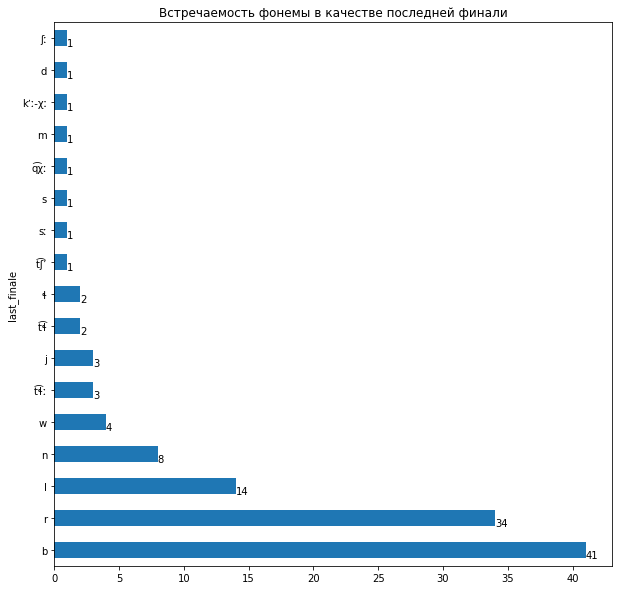

In [35]:
plt.figure(figsize=(10,10))
plt.title('Встречаемость фонемы в качестве последней финали')
plt.ylabel('Инициаль')
lastFinConsCount = dfTarget.where(dfTarget.last_finale_len > 0).groupby('last_finale')['word_id'].nunique().sort_values(ascending=False)
ax = lastFinConsCount.plot(kind='barh', stacked=False)
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()))

In [36]:
dfTarget[(dfTarget['last_finale'] != '#') &
         (dfTarget['last_finale'] != 'b') & 
         (dfTarget['last_finale'] != 'l') & 
         (dfTarget['last_finale'] != 'lː') & 
         (dfTarget['last_finale'] != 'lʷ') & 
         (dfTarget['last_finale'] != 'm') & 
         (dfTarget['last_finale'] != 'mː') & 
         (dfTarget['last_finale'] != 'n') & 
         (dfTarget['last_finale'] != 'r')]

,word_id,borrowing,lemma_source,lemma_ipa,definition,first_init,first_init_len,last_finale,last_finale_len,intervocals,stressed_vowels,stress_index,intervocals_len,n_syllables
585,586,NaN,бацĪамуцĪуд,b-a-t͡s’ː-a-m-u-t͡s’ː-u-d,(_ратл._) _см._ *атIеда*,b,1,d,1,"[t͡s’ː, m, t͡s’ː]",#,0,"[1, 1, 1]",4
610,611,NaN,бачIидилI,b-a-t͡ʃ’-i-d-i-t͡ɬː,(_цег._)* къва*,b,1,t͡ɬː,1,"[t͡ʃ’, d]",#,0,"[1, 1]",3
702,703,NaN,безкъIа/в,b-e-z-q͡χ’-a-w,(_ратл._)* *_см._* ц̄иникъIа*,b,1,w,1,[z-q͡χ’],#,0,[2],2
1244,1245,NaN,бухIличI,b-u-ћ-l-i-t͡ʃ’,(_цег._)_ см_*. чIе̄'дакалIи*,b,1,t͡ʃ’,1,[ћ-l],#,0,[2],2
2105,2106,NaN,гьусгьу'с,h-u-s-h-u'-s,"_межд._ ату-ату (_возглас, которым науськиваю...",h,1,s,1,[s-h],u',2,[2],2
3267,3268,NaN,къай,q͡χ’ː-a-j,"(_цег._, _тл._) _см_*. хеме'*",q͡χ’ː,1,j,1,[],#,0,[],1
3454,3455,NaN,къимищ,q͡χ’ː-i-m-i-ʃː,(_ратл._) _см_*. цĪва'ни*,q͡χ’ː,1,ʃː,1,[m],#,0,[1],2
3582,3583,NaN,къучĪу'/рулъI,q͡χ’ː-u-t͡ʃ’ː-u'-r-u-t͡ɬ,глотать; *ацĪи* *къучĪурулъIа* глотать слюну...,q͡χ’ː,1,t͡ɬ,1,"[t͡ʃ’ː, r]",u',2,"[1, 1]",3
3764,3765,NaN,кьелI,t͡ɬʼː-e-t͡ɬː,(_тл._) _см_*. теретилIи*,t͡ɬʼː,1,t͡ɬː,1,[],#,0,[],1
4156,4157,NaN,кĪварйав,kʼʷː-a-r-j-a-w,"(_ратл._),* кĪоров *(_тл._),* кĪорийав *(_це...",kʼʷː,1,w,1,[r-j],#,0,[2],2


In [37]:
dfTarget[dfTarget['last_finale'] == 'b']

,word_id,borrowing,lemma_source,lemma_ipa,definition,first_init,first_init_len,last_finale,last_finale_len,intervocals,stressed_vowels,stress_index,intervocals_len,n_syllables
56,57,NaN,акъIагьандаб,a-q͡χ’-a-h-a-n-d-a-b,(_ратл._)* *_см_*. тIигьолIи*,#,0,b,1,"[q͡χ’, h, n-d]",#,0,"[1, 1, 2]",4
133,134,NaN,антедаб,a-n-t-e-d-a-b,(_ратл._) _см._* алахIедабе*,#,0,b,1,"[n-t, d]",#,0,"[2, 1]",3
502,503,NaN,батIагуб,b-a-t’-a-g-u-b,(_цег._) _см._* мина-дабехурулъIа / минада̄хур...,b,1,b,1,"[t’, g]",#,0,"[1, 1]",3
609,610,NaN,бачIеб,b-a-t͡ʃ’-e-b,(_тл._)_ см._* къо̄далIигьира*,b,1,b,1,[t͡ʃ’],#,0,[1],2
628,629,NaN,башалдаб,b-a-ʃ-a-l-d-a-b,"(_ратл._),* башараб *(_тл._) _см._* кьу'радабе*",b,1,b,1,"[ʃ, l-d]",#,0,"[1, 2]",3
761,762,NaN,бесхъаб,b-e-s-q͡χː-a-b,"(_ратл._),* бехтаб *(_тл., цег._) _см._* экIва...",b,1,b,1,[s-q͡χː],#,0,[2],2
810,811,NaN,бецендаб,b-e-t͡s-e-n-d-a-b,"( _тл., цег._) _см._* рещедабе / реща̄бе*",b,1,b,1,"[t͡s, n-d]",#,0,"[1, 2]",3
815,816,NaN,бец̄аб,b-e-t͡sː-a-b,"(_тл., цег._)* бец̄одаб *(_ратл._) _см._* рес̄...",b,1,b,1,[t͡sː],#,0,[1],2
942,943,NaN,бикьIедаб,b-i-t͡ɬʼ-e-d-a-b,(_ратл._) _см._* тегьиладабе*,b,1,b,1,"[t͡ɬʼ, d]",#,0,"[1, 1]",3
1561,1562,NaN,гъайнгелаб,ʁ-a-j-n-g-e-l-a-b,"(_тл._),* гъамеб *(_цег._) _см._* зкĪридабе*",ʁ,1,b,1,"[j-n-g, l]",#,0,"[3, 1]",3


In [38]:
dfTarget[
         (dfTarget['last_finale'] == 'b') | 
         (dfTarget['last_finale'] == 'l') | 
         (dfTarget['last_finale'] == 'lː') | 
         (dfTarget['last_finale'] == 'lʷ') | 
         (dfTarget['last_finale'] == 'm') | 
         (dfTarget['last_finale'] == 'mː') | 
         (dfTarget['last_finale'] == 'n') |
         (dfTarget['last_finale'] == 'r')]

,word_id,borrowing,lemma_source,lemma_ipa,definition,first_init,first_init_len,last_finale,last_finale_len,intervocals,stressed_vowels,stress_index,intervocals_len,n_syllables
38,39,NaN,ажихъан,a-ʒ-i-q͡χː-a-n,"*, ажихъане *(_ратл._),* икьел *(_цег_*.*)* *_...",#,0,n,1,"[ʒ, q͡χː]",#,0,"[1, 1]",3
56,57,NaN,акъIагьандаб,a-q͡χ’-a-h-a-n-d-a-b,(_ратл._)* *_см_*. тIигьолIи*,#,0,b,1,"[q͡χ’, h, n-d]",#,0,"[1, 1, 2]",4
133,134,NaN,антедаб,a-n-t-e-d-a-b,(_ратл._) _см._* алахIедабе*,#,0,b,1,"[n-t, d]",#,0,"[2, 1]",3
152,153,NaN,аргъан,a-r-ʁ-a-n,"(_тл.,цег._),* аргъане *(_ратл._)* *_см_*. нак...",#,0,n,1,[r-ʁ],#,0,[2],2
247,248,NaN,ачIа'л,a-t͡ʃ’-a'-l,_числ._ десять (_служит для образования соста...,#,0,l,1,[t͡ʃ’],a',2,[1],2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7575,7576,NaN,чIобидаб,t͡ʃ’-o-b-i-d-a-b,(_ратл._) _см._* зоридаб*,t͡ʃ’,1,b,1,"[b, d]",#,0,"[1, 1]",3
7682,7683,NaN,шарабукъудаб,ʃ-a-r-a-b-u-q͡χ’ː-u-d-a-b,"(_ратл._),* шарабукъаб *(_цег._) _см._* шарачI...",ʃ,1,b,1,"[r, b, q͡χ’ː, d]",#,0,"[1, 1, 1, 1]",5
7725,7726,NaN,шинтил,ʃ-i-n-t-i-l,(_ратл._) _см_*. къазима*,ʃ,1,l,1,[n-t],#,0,[2],2
7726,7727,NaN,шинтир,ʃ-i-n-t-i-r,(_ратл._) _см_*. къазима*,ʃ,1,r,1,[n-t],#,0,[2],2


In [39]:
#Все варианты с "b" на конце – это диалектные формы

In [40]:
finale_counter = {'тл': 0, "цег": 0, "ратл": 0, "н/а": 0}
non_dialect = []
total = 0
for _, row in dfTarget[(dfTarget['last_finale'] != "#")].iterrows():
    total += 1
    dialects = ['тл', "цег", "ратл"]
    foundDialect = False
    for d in dialects:
        pattern = "_?[_,]" + d + '[_\.]_?'
        if re.search(pattern, row['definition']):
            finale_counter[d] += 1
            foundDialect = True
    if not foundDialect:
        finale_counter["н/а"] += 1
        non_dialect.append(row)
        
finale_counter, total

({'тл': 70, 'цег': 42, 'ратл': 53, 'н/а': 6}, 119)

In [41]:
for row in non_dialect:
    print(row)

word_id                                                          248
borrowing                                                        NaN
lemma_source                                                  ачIа'л
lemma_ipa                                                a-t͡ʃ’-a'-l
definition          _числ._ десять (_служит для образования соста...
first_init                                                         #
first_init_len                                                     0
last_finale                                                        l
last_finale_len                                                    1
intervocals                                                   [t͡ʃ’]
stressed_vowels                                                   a'
stress_index                                                       2
intervocals_len                                                  [1]
n_syllables                                                        2
Name: 247, dtype: object
word_id  

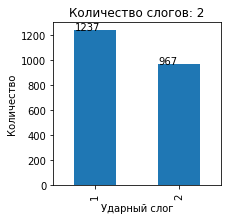

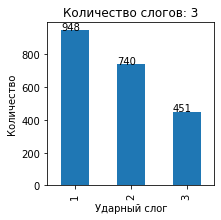

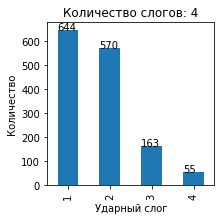

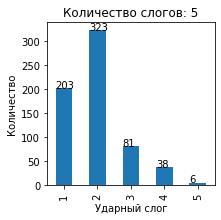

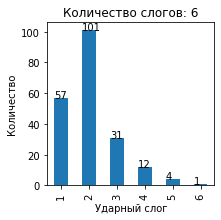

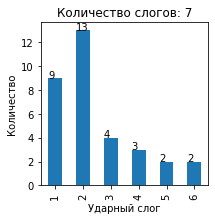

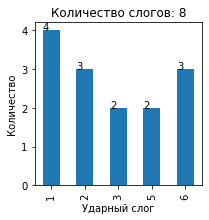

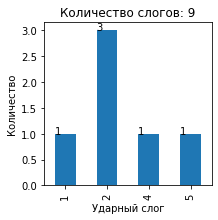

In [86]:
for nS in range(2,10):
    plt.figure(figsize=(3,3))
    ax = dfTarget[
        (dfTarget['n_syllables'] == nS) & (dfTarget['stress_index'] != 0)
    ]['stress_index'].value_counts().sort_index().plot(kind='bar', use_index=True)
    
    plt.title('Количество слогов: %d' % (nS))
    plt.xlabel('Ударный слог')
    plt.ylabel('Количество')
    
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()))

In [43]:
intervocalCounter = Counter()
for _, row in dfTarget.iterrows():
    for l in row.intervocals_len:
        intervocalCounter[l] += 1
        if l == 3:
            print(row)

word_id                                                     1562
borrowing                                                    NaN
lemma_source                                          гъайнгелаб
lemma_ipa                                      ʁ-a-j-n-g-e-l-a-b
definition         (_тл._),* гъамеб *(_цег._) _см._* зкĪридабе*
first_init                                                     ʁ
first_init_len                                                 1
last_finale                                                    b
last_finale_len                                                1
intervocals                                           [j-n-g, l]
stressed_vowels                                                #
stress_index                                                   0
intervocals_len                                           [3, 1]
n_syllables                                                    3
Name: 1561, dtype: object
word_id                                     1735
borrowing      

In [44]:
intervocalCounter

Counter({1: 16230, 2: 455, 3: 3})

<Figure size 360x216 with 0 Axes>

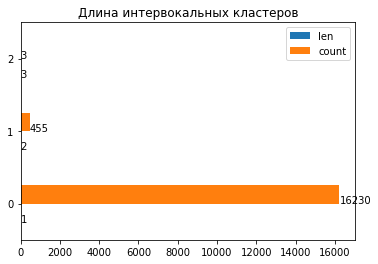

In [71]:
plt.figure(figsize=(5,3))

ax = pd.DataFrame.from_dict({
    'len': list(intervocalCounter.keys()),
    'count': list(intervocalCounter.values())
                            }, orient='columns').plot(kind='barh')
plt.title('Длина интервокальных кластеров')
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()))
plt.show()

Посмотрим на интервокальные кластеры длиной 2. Первый согласный этого кластера – это финаль (довольно редкого – всего 2,72% не в конечной позиции) CVC-слога.

In [45]:
cc_list = []
for _, row in dfTarget.iterrows():
    for i, l in enumerate(row.intervocals_len):
        if l == 2:
            cc_list.append(row.intervocals[i].split('-'))

In [46]:
typeOfFinale = Counter()
for c in cc_list:
    fin = c[0]
    if fin == "b":
        typeOfFinale["b"] += 1
    elif fin in sonorList:
        typeOfFinale["L"] += 1
    else:
        typeOfFinale["C"] += 1

In [47]:
print(typeOfFinale)
print({k: round((typeOfFinale[k] / sum(typeOfFinale.values())), 4) for k in typeOfFinale})

Counter({'C': 306, 'L': 142, 'b': 7})
{'L': 0.3121, 'C': 0.6725, 'b': 0.0154}


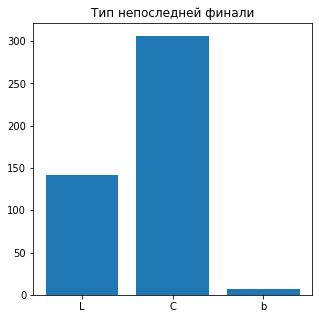

In [60]:
plt.figure(figsize=(5,5))
plt.title('Тип непоследней финали')
ax = plt.bar(typeOfFinale.keys(), typeOfFinale.values())

plt.show()

In [51]:
typeOfLastFinale = Counter()
for _, row in dfTarget.iterrows():
    if row.last_finale != "#":
        fin = row.last_finale
        if fin == "b":
            typeOfLastFinale["b"] += 1
        elif fin in sonorList:
            typeOfLastFinale["L"] += 1
        else:
            typeOfLastFinale["C"] += 1

In [49]:
print(typeOfLastFinale)
print({k: round((typeOfLastFinale[k] / sum(typeOfLastFinale.values())), 4) for k in typeOfLastFinale})

Counter({'L': 57, 'b': 41, 'C': 21})
{'L': 0.479, 'b': 0.3445, 'C': 0.1765}


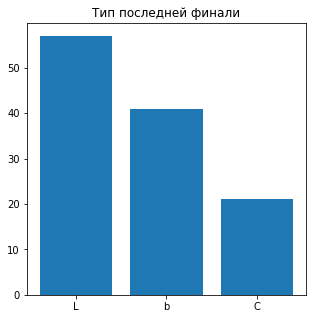

In [61]:
plt.figure(figsize=(5,5))
plt.title('Тип последней финали')
ax = plt.bar(typeOfLastFinale.keys(), typeOfLastFinale.values())

plt.show()

In [52]:
typeOfFirstInit = Counter()

for _, row in dfTarget.iterrows():
    if row.first_init != "#":
        fin = row.first_init
        if fin == "b":
            typeOfFirstInit["b"] += 1
        elif fin in sonorList:
            typeOfFirstInit["L"] += 1
        else:
            typeOfFirstInit["C"] += 1
            
print(typeOfFirstInit)

Counter({'C': 5016, 'L': 950, 'b': 918})


In [57]:
typeOfConsGlob = {"b": 0, "L": 0, "C": 0}

for _, row in phonFreqDF.iterrows():
    if row.phoneme not in vowels_all:
        fin = row.phoneme
        if fin == "b":
            typeOfConsGlob["b"] += row['count']
            typeOfConsGlob["C"] += row['count']
        elif fin in sonorList:
            typeOfConsGlob["L"] += row['count']
        else:
            typeOfConsGlob["C"] += row['count']
            
print(typeOfConsGlob)

{'b': 950, 'L': 5049, 'C': 17992}


In [81]:
_1sylDict = Counter()

for _, row in dfTarget.iterrows():
    
    if row.n_syllables == 1:
        word_schem = ''
        for p in phonListMaker(row.lemma_ipa):
            if p in vowels_all:
                word_schem += 'V'
            elif p in sonorList:
                word_schem += "L"
            else:
                word_schem += "C"
        if len(re.findall('V', word_schem)) == 1:
            _1sylDict[word_schem] += 1

In [ ]:
_1sylDict

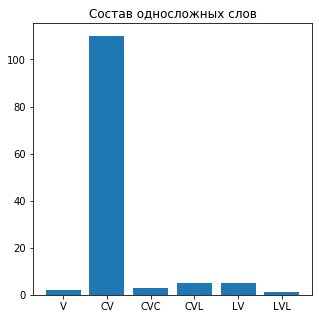

In [85]:

plt.figure(figsize=(5,5))
plt.title('Состав односложных слов')
plt.bar(x=_1sylDict.keys(), height=_1sylDict.values())
plt.show()

In [87]:
_2sylDict = Counter()
for _, row in dfTarget.iterrows():
    
    if row.n_syllables == 2:
        word_schem = ''
        for p in phonListMaker(row.lemma_ipa):
            if p in vowels_all:
                word_schem += 'V'
            elif p in sonorList:
                word_schem += "L"
            else:
                word_schem += "C"
        if len(re.findall('V', word_schem)) == 2:
            _2sylDict[word_schem] += 1

In [88]:
_2sylDict

Counter({'VCV': 137,
         'VCCV': 6,
         'VLLV': 1,
         'VLCV': 5,
         'VLCVL': 1,
         'VCVL': 3,
         'CVCV': 927,
         'CVCVL': 14,
         'CVCLV': 12,
         'CVLCV': 21,
         'CVLCVL': 9,
         'CVLV': 376,
         'CVCVC': 3,
         'CVCCVC': 4,
         'CVCLVC': 2,
         'CVCCV': 21,
         'CVCCVL': 2,
         'VCLV': 1,
         'VCVC': 2,
         'VLV': 4,
         'CVLVL': 3,
         'CVLCCV': 1,
         'CVLVC': 1,
         'CVLCVC': 3,
         'LVCV': 247,
         'LVLCV': 1,
         'LVLV': 8,
         'CVCLVL': 1,
         'LVCLV': 7,
         'LVCCV': 6,
         'LVCVC': 4,
         'LVLVL': 1,
         'LVCVL': 1,
         'CVCVCC': 1})

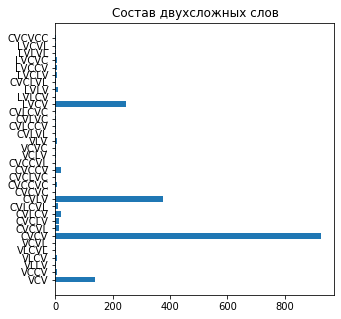

In [92]:

plt.figure(figsize=(5,5))
plt.title('Состав двухсложных слов')
plt.barh(y=list(_2sylDict.keys()), width=list(_2sylDict.values()))
plt.show()

In [93]:
# процент лабиализованных
sum([x.group_percentage for _, x in phonFreqDF.iterrows() if "ʷ" in x.phoneme])

0.04834859598107722

In [94]:
phonFreqDF['total_vowels'] / phonFreqDF['total']

a        0.51694
e        0.51694
i        0.51694
u        0.51694
r        0.51694
          ...   
t͡sʷː    0.51694
ʔʷ       0.51694
ʕʷ       0.51694
ũː      0.51694
lʷ       0.51694
Length: 107, dtype: float64